# Randomization analysis

In this notebook we investigate whether interactions with an unbalance of simple and twisted read pairs occur more often than expected by chance. Similar to the FDR procedure, we randomize the simple and twisted read pair counts in each interaction according to a binomial distribution with $p=0.5$ and then determine the total number of significant interactions at a given nominal alpha. But instead of doing only one iteration of this procedure, as we do for estimating the FDR, we do many interations, e.g. ``10,000``. If we never observe more significant interactions than for the non-randomized data, we speak of an empirical P-value of ``1/10000``. In addition, we calculate the mean and standard devaition for the numbers of randomized significant interactions from all iterations, and from this, in turn, a Z-score.

## Setting up the notebook

In [1]:
import sys
import os
from numpy import arange
import pandas
sys.path.append("..")
from diachr import DiachromaticInteractionSet
from diachr import RandomizeInteractionSet

In this notebook, we use the following classes and functions:
* ``DiachromaticInteractionSet``
    - ``parse_file``: Read interactions from file
    - ``get_read_file_info_report``: Get information about files that have already been read in form of a formatted string
* ``RandomizeInteractionSet``
    - ``perform_randomization_analysis``: The entire randomzation analysis is carried out in this function using sub-functions that are also used for the FDR procedure, which is also implemented in ``RandomizeInteractionSet``

We use the ``DiachromaticInteractionSet`` to read interactions from a file. The FDR procedure is carried out in class ``RandomizeInteractionSet``, which operates on an already existing ``DiachromaticInteractionSet`` object that has been passed to its constructor.

## Test files

### Test file 1

We use the test file with ``64,000`` interactions, which we also use to test the FDR procedure.

In [2]:
ls ../tests/data/test_03/*top_64000*

../tests/data/test_03/diachromatic_interaction_file_fdr_top_64000.tsv.gz


## Demonstration of the analysis using the test file with ``64,000`` interactions

First, we read the interaction file into an interaction set.

In [2]:
interaction_set = DiachromaticInteractionSet()
interaction_set.parse_file('../tests/data/test_03/diachromatic_interaction_file_fdr_top_64000.tsv.gz', verbose=True)
read_file_info_report = interaction_set.get_read_file_info_report()
print(read_file_info_report)

[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../tests/data/test_03/diachromatic_interaction_file_fdr_top_64000.tsv.gz
[INFO] ... done.
[INFO] Report on reading files:
	[INFO] Read interaction data from 1 files:
		[INFO] 64,000 interactions from: 
			[INFO] ../tests/data/test_03/diachromatic_interaction_file_fdr_top_64000.tsv.gz
			[INFO] Set size: 64,000
	[INFO] The interaction set has 64,000 interactions.
[INFO] End of report.



Next, we create an object of class ``RandomizeInteractionSet`` and pass the interaction set to this object.

In [3]:
randomization_analysis = RandomizeInteractionSet(interaction_set=interaction_set)

Then we call the function ``perform_randomization_analysis`` of the class ``RandomizeInteractionSet`` in which the entire randomization analysis is implemented. To this function, a ``nominal_alpha`` is passed, which is used as the P-value threshold. Interactions that have a smaller P-value are counted as significant.

In addition, the number of iterations can be specified (``iter_num`` defaults to ``1,000``).

### Paralell processing

Dependinng on the innput parameters, the analysis can be computational intensive. Therefore, batches of iterations can be performed out in paralell processes. If ``thread_num=0`` (default), the Python package ``multiprocessing`` is not used and all iterations are performed in sequence. If ``thread_num=1``, then the ``multiprocessing`` package is used, but all iterations are performed in a single process. If ``1 < thread_num``, the iterations are divided into batches that are performed in paralell processes. We use a different random seed for each iteration. Overall, however, we use the same seeds so that the same result is obtained, regardless of whether the iterations are performed in one or more processes. We implemented this in this way in order to be able to test the paralellization in a unit test.

In [23]:
import time
start = time.time()
randomization_analysis_info_dict = randomization_analysis.perform_randomization_analysis(
    nominal_alpha = 0.0025,
    iter_num = 1000,
    thread_num=2,
    verbose = True)
end = time.time()
print("\nRuntime: " + str(end-start) + '\n')
print(randomization_analysis.get_randomization_info_report())

[INFO] Performing randomization analysis with 1000 iterations ...
	[INFO] Determining number of significant interactions at nominal alpha ...
	[INFO] Randomizing interactions ...
		[INFO] Batch: Performing 500 iterations ...
			[INFO] First iteration indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9 ,...
		[INFO] Batch: Performing 500 iterations ...
			[INFO] First iteration indices: [500, 501, 502, 503, 504, 505, 506, 507, 508, 509 ,...
	[INFO] Calculating summary statistics ...
[INFO] ... done.

Runtime: 53.8504581451416

[INFO] Report on randomization analysis:
	[INFO] Input parameters:
		[INFO] Nominal alpha: 0.00250
		[INFO] Number of iterations: 1,000
		[INFO] Number of input interactions: 64,000
	[INFO] Results:
		[INFO] Original number of significant interactions: 1,424
		[INFO] Number of randomized interactions: 38,749
		[INFO] First 10 significant randomized interaction numbers: 
			[52, 50, 45, 60, 43, 43, 46, 48, 47, 60 ,...
		[INFO] Mean number of significant randomized interactions:

In [20]:
pandas.DataFrame(randomization_analysis_info_dict['RESULTS']['SUMMARY'])

,SIG_NUM_O,I_NUM_RANDOMIZED,SIG_NUM_R_MEAN,SIG_NUM_R_STD,Z_SCORE
0,1424,38749,51.01,6.902891,198.90073


### Develop a plot to be generated automatically in future

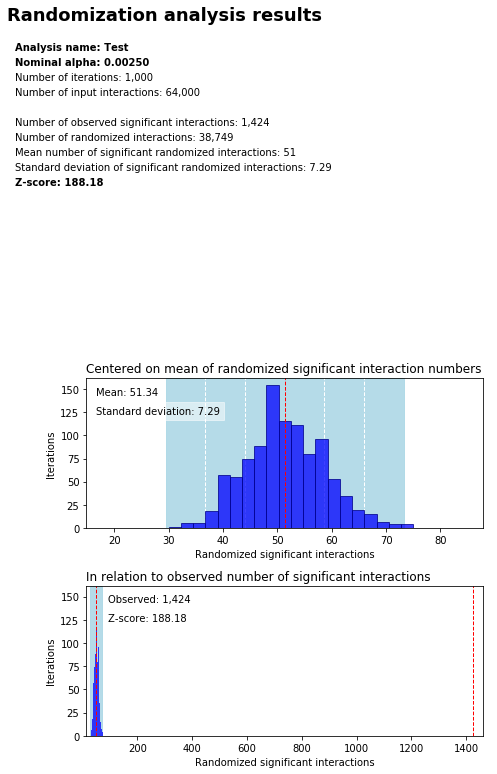

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

header_font_size = 10

analysis_name = 'Test'
nominal_alpha = randomization_analysis_info_dict['INPUT_PARAMETERS']['NOMINAL_ALPHA'][0]
iter_num = randomization_analysis_info_dict['INPUT_PARAMETERS']['ITER_NUM'][0]
input_interactions_num = randomization_analysis_info_dict['INPUT_PARAMETERS']['INPUT_INTERACTIONS_NUM'][0]

sig_num_r_list = randomization_analysis_info_dict['RESULTS']['SIG_NUM_R_LIST']
sig_num_o = randomization_analysis_info_dict['RESULTS']['SUMMARY']['SIG_NUM_O'][0]
i_num_randomized = randomization_analysis_info_dict['RESULTS']['SUMMARY']['I_NUM_RANDOMIZED'][0]
sig_num_r_mean = randomization_analysis_info_dict['RESULTS']['SUMMARY']['SIG_NUM_R_MEAN'][0]
sig_num_r_sd = randomization_analysis_info_dict['RESULTS']['SUMMARY']['SIG_NUM_R_STD'][0]
z_score = float(randomization_analysis_info_dict['RESULTS']['SUMMARY']['Z_SCORE'][0])


fig, ax = plt.subplots(3, figsize=(7, 10.86), gridspec_kw={'height_ratios': [2, 1, 1]})

# Add field with information about analysis
plt.plot(ax=ax[0])
ax[0].spines['left'].set_color('white')
ax[0].spines['right'].set_color('white')
ax[0].spines['top'].set_color('white')
ax[0].spines['bottom'].set_color('white')
ax[0].tick_params(axis='x', colors='white')
ax[0].tick_params(axis='y', colors='white')
ax[0].text(-0.2, 1.00, 'Randomization analysis results', fontsize=18, fontweight='bold')
ax[0].text(-0.18, 0.90, 'Analysis name: ' + analysis_name, fontsize=header_font_size, fontweight='bold')
ax[0].text(-0.18, 0.85, 'Nominal alpha: ' + "{:.5f}".format(nominal_alpha),
           fontsize=header_font_size, fontweight='bold')
ax[0].text(-0.18, 0.80, 'Number of iterations: ' + "{:,}".format(iter_num),
           fontsize=header_font_size)
ax[0].text(-0.18, 0.75, 'Number of input interactions: ' + "{:,}".format(input_interactions_num),
           fontsize=header_font_size)

ax[0].text(-0.18, 0.65, 'Number of observed significant interactions: ' + "{:,}".format(sig_num_o),
           fontsize=header_font_size)
ax[0].text(-0.18, 0.60, 'Number of randomized interactions: ' + "{:,}".format(i_num_randomized),
           fontsize=header_font_size)
ax[0].text(-0.18, 0.55, 'Mean number of significant randomized interactions: ' + "{:,.0f}".format(round(sig_num_r_mean)),
           fontsize=header_font_size)
ax[0].text(-0.18, 0.50, 'Standard deviation of significant randomized interactions: ' + "{:.2f}".format(sig_num_r_sd),
           fontsize=header_font_size)
ax[0].text(-0.18, 0.45, 'Z-score: ' + "{:.2f}".format(z_score), fontsize=header_font_size, fontweight='bold')


# Plot distribution of iterations centered on mean of randomized significant interaction numbers
n, bins, patches = ax[1].hist(sig_num_r_list, 20, density=False, facecolor='b', alpha=0.75, edgecolor='darkblue')
ax[1].set_xlim(sig_num_r_mean - 5*sig_num_r_sd, sig_num_r_mean + 5*sig_num_r_sd)

ax[1].set_title('Centered on mean of randomized significant interaction numbers', loc='left')
ax[1].set_xlabel('Randomized significant interactions')
ax[1].set_ylabel('Iterations')

ax[1].axvspan(sig_num_r_mean - 3*sig_num_r_sd, sig_num_r_mean + 3*sig_num_r_sd, color='lightblue', alpha=0.9, zorder=0)

ax[1].axvline(sig_num_r_mean, linestyle='--', color='red', linewidth=1)
ax[1].axvline(sig_num_r_mean - 2*sig_num_r_sd, linestyle='--', color='w', linewidth=1, zorder=0)
ax[1].axvline(sig_num_r_mean - 1*sig_num_r_sd, linestyle='--', color='w', linewidth=1, zorder=0)
ax[1].axvline(sig_num_r_mean + 1*sig_num_r_sd, linestyle='--', color='w', linewidth=1, zorder=0)
ax[1].axvline(sig_num_r_mean + 2*sig_num_r_sd, linestyle='--', color='w', linewidth=1, zorder=0)

y_pos_lab = max(n) - max(n)/15
x_pos_lab = sig_num_r_mean - 4.75*sig_num_r_sd
ax[1].text(x_pos_lab, y_pos_lab,'Mean: ' + "{:.2f}".format(sig_num_r_mean), bbox={'color': 'w', 'alpha': 0.5, 'pad': 4})
y_pos_lab = max(n) - 3*(max(n)/15)
ax[1].text(x_pos_lab, y_pos_lab,'Standard deviation: ' + "{:.2f}".format(sig_num_r_sd), bbox={'color': 'w', 'alpha': 0.5, 'pad': 4})

# Plot distribution of iterations in relation to observed number of significant interactions
n, bins, patches = ax[2].hist(sig_num_r_list, 20, density=False, facecolor='b', alpha=0.75)
ax[2].set_xlim(sig_num_r_mean - 5*sig_num_r_sd, sig_num_o + 5*sig_num_r_sd)

ax[2].set_title('In relation to observed number of significant interactions', loc='left')
ax[2].set_xlabel('Randomized significant interactions')
ax[2].set_ylabel('Iterations')

ax[2].axvspan(sig_num_r_mean - 3*sig_num_r_sd, sig_num_r_mean + 3*sig_num_r_sd, color='lightblue', alpha=0.9, zorder=0)
ax[2].axvline(sig_num_r_mean, linestyle='--', color='red', linewidth=1)
ax[2].axvline(sig_num_o, linestyle='--', color='red', linewidth=1)

y_pos_lab = max(n) - max(n)/15
x_pos_lab = sig_num_r_mean + 6*sig_num_r_sd
ax[2].text(x_pos_lab, y_pos_lab,'Observed: ' + "{:,}".format(sig_num_o), bbox={'color': 'w', 'alpha': 0.5, 'pad': 4})
y_pos_lab = max(n) - 3*(max(n)/15)
ax[2].text(x_pos_lab, y_pos_lab,'Z-score: ' + "{:.2f}".format(z_score), bbox={'color': 'w', 'alpha': 0.5, 'pad': 4})



fig.tight_layout()




## Results of the randomization depending on the number of input interactions

XXX

## Results of the randomization depending on the nominal alpha

XXX

In [86]:
(19/7)*4

10.857142857142858